# Model Building

In [39]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from scipy.stats import skew, boxcox
from scipy import sparse
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics, preprocessing
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [40]:
df = pd.read_csv('../data/input_proc2.csv')

In [41]:
train = pd.read_csv('../ProjectFiles/File2.csv')
train_size = train.shape[0]
df.SPENDINGRESPONSE[train_size:].isnull().sum()

9231

In [42]:
test_size = df.shape[0]-train_size
test_size

9231

In [43]:
print(df.columns.values)

['ID' 'f3_A' 'f3_B' 'f3_C' 'f3_D' 'f3_E' 'f3_F' 'f3_G' 'f3_H' 'f3_I'
 'f3_J' 'f3_K' 'f3_L' 'f3_M' 'f3_N' 'f3_O' 'f3_P' 'f3_Q' 'f3_R' 'f3_nan'
 'f12_A' 'f12_B' 'f12_C' 'f12_D' 'f12_E' 'f12_nan' 'f13_A' 'f13_B' 'f95_A'
 'f95_B' 'f95_C' 'f95_D' 'f95_E' 'f95_F' 'f96_A' 'f96_B' 'f96_G' 'f96_J'
 'f97_A' 'f97_B' 'f97_C' 'f97_D' 'f97_E' 'f97_F' 'f97_G' 'f97_H' 'f97_I'
 'f97_J' 'f98_A' 'f98_B' 'f98_G' 'f98_J' 'f99_A' 'f99_B' 'f99_C' 'f99_D'
 'f99_E' 'f99_F' 'f99_G' 'f99_H' 'f99_I' 'f99_J' 'f100_A' 'f100_B'
 'f100_G' 'f100_J' 'f101_A' 'f101_B' 'f101_C' 'f101_D' 'f101_E' 'f101_F'
 'f101_G' 'f101_H' 'f101_I' 'f101_J' 'f102_A' 'f102_B' 'f102_G' 'f102_J'
 'f103_A' 'f103_B' 'f103_C' 'f103_D' 'f103_E' 'f103_F' 'f103_G' 'f103_H'
 'f103_I' 'f103_J' 'f108_A' 'f108_B' 'f108_C' 'f108_D' 'f108_E' 'f108_F'
 'f108_G' 'f108_H' 'f108_I' 'f108_J' 'f108_K' 'f108_L' 'f108_M' 'f108_N'
 'f108_O' 'f108_nan' 'f110_1' 'f110_2' 'f110_3' 'f110_4' 'f110_A' 'f110_B'
 'f110_C' 'f110_D' 'f110_E' 'f110_F' 'f110_G' 'f110_H' 'f

In [44]:
df_test = df.drop('ID', axis=1).values
train_x = df[:train_size].drop(['ID','SPENDINGRESPONSE'], axis=1).values
train_y = df[:train_size].SPENDINGRESPONSE.values

## Modeling: XGBoost

XGBoost is a popular model recently, especially in Kaggel competition, due to its good performance. XGBoost also has a unique way of dealing with missing values which tend to be effective most of the time. By default, the assume Nan as missing value and would try to create splitting point for those samples with Nan.

In [245]:
dtrain = xgb.DMatrix(train_x, label=train_y, missing = np.NAN)

**Parameter tuning: manual**

(1) Max_depth

In [46]:
%%time
scores = []
for max_depth in [5, 6, 7, 8, 9, 10]:

    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.1
    params['max_depth'] = max_depth
    params['min_child_weight'] = 1
    params['colsample_bytree'] = 1
    params['subsample'] = 1
    params['gamma'] = 0
    params['seed'] = 1234
    #params['eval_metric'] = 'error'
    cv_results = xgb.cv(params, dtrain,
                    num_boost_round=10000,
                    nfold=5,
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=500,
                    seed=1234,
                    early_stopping_rounds=50)

    best_score = cv_results['test-error-mean'].min()
    best_iteration = len(cv_results)           
    print(max_depth, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_max_depth = scores.sort_values(by='score', ascending=True)['max_depth'].values[0]
print('Best max_depth is', best_max_depth)    

[0]	train-error:0.302975+0.00140412	test-error:0.31265+0.00225068
5 0.3126502 1
[0]	train-error:0.299575+0.00262243	test-error:0.3141+0.00209017
6 0.31410020000000005 1
[0]	train-error:0.29435+0.00387018	test-error:0.31785+0.00441711
7 0.31784999999999997 1
[0]	train-error:0.28885+0.00523213	test-error:0.321+0.00534901
8 0.3210002 2
[0]	train-error:0.280837+0.00641142	test-error:0.328699+0.00653888
9 0.3286994 1
[0]	train-error:0.2691+0.00783301	test-error:0.3357+0.00358389
10 0.3356996 1
Best max_depth is 5
CPU times: user 15min 28s, sys: 11.1 s, total: 15min 39s
Wall time: 4min 27s


(2) Min_child_weight

In [47]:
%%time
scores = []
for min_child_weight in [1, 10, 25, 50, 100]:

    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.1
    params['max_depth'] = best_max_depth
    params['min_child_weight'] = min_child_weight
    params['colsample_bytree'] = 1
    params['subsample'] = 1
    params['gamma'] = 0
    params['seed'] = 1234
    cv_results = xgb.cv(params, dtrain,
                    num_boost_round=10000,
                    nfold=5,
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=500,
                    seed=1234,
                    early_stopping_rounds=50)

    
    best_score = cv_results['test-error-mean'].min()
    best_iteration = len(cv_results)           
    print(min_child_weight, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_min_child_weight = scores.sort_values(by='score', ascending=True)['min_child_weight'].values[0]
print('Best min_child_weight is', best_min_child_weight)    

[0]	train-error:0.302975+0.00140412	test-error:0.31265+0.00225068
1 0.3126502 1
[0]	train-error:0.305238+0.000921155	test-error:0.31395+0.00230289
10 0.31395019999999996 1
[0]	train-error:0.307637+0.000609447	test-error:0.31165+0.00164451
25 0.3116502 1
[0]	train-error:0.30845+1.74172e-05	test-error:0.30845+6.83491e-05
[500]	train-error:0.161162+0.00981326	test-error:0.3268+0.00304444
50 0.30835 810
[0]	train-error:0.30845+1.74172e-05	test-error:0.30845+6.83491e-05
[500]	train-error:0.2039+0.00582721	test-error:0.323351+0.00433734
100 0.30845 798
Best min_child_weight is 50
CPU times: user 1h 18s, sys: 20.7 s, total: 1h 39s
Wall time: 17min 2s


(3) Colsample_bytree

In [48]:
%%time
scores = []
for colsample_bytree in [0.1, 0.3, 0.5, 0.7, 0.9]:

    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.1
    params['max_depth'] = best_max_depth
    params['min_child_weight'] = best_min_child_weight
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = 1
    params['gamma'] = 0
    params['seed'] = 1234
    cv_results = xgb.cv(params, dtrain,
                    num_boost_round=10000,
                    nfold=5,
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=500,
                    seed=1234,
                    early_stopping_rounds=50)

    
    best_score = cv_results['test-error-mean'].min()
    best_iteration = len(cv_results)           
    print(colsample_bytree, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_colsample_bytree = scores.sort_values(by='score', ascending=True)['colsample_bytree'].values[0]
print('Best colsample_bytree is', best_colsample_bytree)    

[0]	train-error:0.30845+1.74172e-05	test-error:0.30845+6.83491e-05
[500]	train-error:0.219162+0.00282059	test-error:0.31935+0.00207913
[1000]	train-error:0.118287+0.00293347	test-error:0.334201+0.00383474
0.1 0.30845 1087
[0]	train-error:0.30845+1.74172e-05	test-error:0.30845+6.83491e-05
[500]	train-error:0.188937+0.00393302	test-error:0.3217+0.00210782
[1000]	train-error:0.082875+0.00535518	test-error:0.33575+0.00459302
0.3 0.3084 1043
[0]	train-error:0.30845+1.74172e-05	test-error:0.30845+6.83491e-05
0.5 0.30845 3
[0]	train-error:0.30845+1.74172e-05	test-error:0.30845+6.83491e-05
0.7 0.30845 2
[0]	train-error:0.30845+1.74172e-05	test-error:0.30845+6.83491e-05
[500]	train-error:0.166475+0.0140687	test-error:0.32525+0.00288888
0.9 0.30845 945
Best colsample_bytree is 0.3
CPU times: user 47min 57s, sys: 30 s, total: 48min 27s
Wall time: 14min 20s


(4) Subsample

In [49]:
%%time
scores = []
for subsample in [0.1, 0.3, 0.5, 0.7, 0.9]:

    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.1
    params['max_depth'] = best_max_depth
    params['min_child_weight'] = best_min_child_weight
    params['colsample_bytree'] = best_colsample_bytree
    params['subsample'] = subsample 
    params['gamma'] = 0
    params['seed'] = 1234
    cv_results = xgb.cv(params, dtrain,
                    num_boost_round=10000,
                    nfold=5,
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=500,
                    seed=1234,
                    early_stopping_rounds=50)

    
    best_score = cv_results['test-error-mean'].min()
    best_iteration = len(cv_results)           
    print(subsample, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_subsample = scores.sort_values(by='score', ascending=True)['subsample'].values[0]
print('Best subsample is', best_subsample)  

[0]	train-error:0.30845+1.74172e-05	test-error:0.30845+6.83491e-05
0.1 0.30845 1
[0]	train-error:0.30845+1.74172e-05	test-error:0.30845+6.83491e-05
[500]	train-error:0.225888+0.00121736	test-error:0.336201+0.00387766
0.3 0.30845 654
[0]	train-error:0.30845+1.74172e-05	test-error:0.30845+6.83491e-05
[500]	train-error:0.191687+0.00182229	test-error:0.3333+0.00425234
0.5 0.30845 892
[0]	train-error:0.309112+0.00134042	test-error:0.3101+0.00323944
0.7 0.31010039999999994 1
[0]	train-error:0.30845+1.74172e-05	test-error:0.30845+6.83491e-05
[500]	train-error:0.181412+0.00240515	test-error:0.3223+0.00305876
[1000]	train-error:0.0706248+0.00202878	test-error:0.338+0.00190962
0.9 0.30845 1005
Best subsample is 0.1
CPU times: user 29min 21s, sys: 23.1 s, total: 29min 44s
Wall time: 8min 27s


(5) Gamma

In [50]:
%%time
scores = []
for gamma in [0, 0.5, 1, 1.5, 2]:

    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.1
    params['max_depth'] = best_max_depth
    params['min_child_weight'] = best_min_child_weight
    params['colsample_bytree'] = best_colsample_bytree
    params['subsample'] = best_subsample 
    params['gamma'] = gamma
    params['seed'] = 1234
    cv_results = xgb.cv(params, dtrain,
                    num_boost_round=1000,
                    nfold=5,
                    maximize=True, 
                    stratified=True,
                    shuffle=True,
                    verbose_eval=500,
                    seed=1234,
                    early_stopping_rounds=50)

    
    best_score = cv_results['test-error-mean'].min()
    best_iteration = len(cv_results)           
    print(gamma, best_score, best_iteration)
    scores.append([best_score, params['eta'], params['max_depth'], params['min_child_weight'],
                   params['colsample_bytree'], params['subsample'], params['gamma'], best_iteration])

scores = pd.DataFrame(scores, columns=['score', 'eta', 'max_depth', 'min_child_weight',
                                       'colsample_bytree', 'subsample', 'gamma', 'best_iteration'])
best_gamma = scores.sort_values(by='score', ascending=True)['gamma'].values[0]
print('Best gamma is', best_gamma)    

[0]	train-error:0.30845+1.74172e-05	test-error:0.30845+6.83491e-05
0 0.30845 1
[0]	train-error:0.30845+1.74172e-05	test-error:0.30845+6.83491e-05
0.5 0.30845 1
[0]	train-error:0.30845+1.74172e-05	test-error:0.30845+6.83491e-05
[500]	train-error:0.298675+0.00093969	test-error:0.3264+0.00317179
1 0.30845 796
[0]	train-error:0.30845+1.74172e-05	test-error:0.30845+6.83491e-05
[500]	train-error:0.299338+0.00102359	test-error:0.32685+0.00318256
1.5 0.30845 634
[0]	train-error:0.30845+1.74172e-05	test-error:0.30845+6.83491e-05
[500]	train-error:0.299375+0.00176965	test-error:0.3272+0.0031828
2 0.30845 478
Best gamma is 0.0
CPU times: user 10min 1s, sys: 13.8 s, total: 10min 15s
Wall time: 3min 6s


In [51]:
print(best_max_depth, best_min_child_weight,
      best_colsample_bytree, best_subsample, best_gamma)

scores.sort_values(by='score',ascending=False)

5 50 0.3 0.1 0.0


,score,eta,max_depth,min_child_weight,colsample_bytree,subsample,gamma,best_iteration
0,0.30845,0.1,5,50,0.3,0.1,0.0,1
1,0.30845,0.1,5,50,0.3,0.1,0.5,1
2,0.30845,0.1,5,50,0.3,0.1,1.0,796
3,0.30845,0.1,5,50,0.3,0.1,1.5,634
4,0.30845,0.1,5,50,0.3,0.1,2.0,478


**Parameter tuning: automated**

Bayesian optimization is used for automated parameter tuning. It works by constructing a posterior distribution of functions that best describes the function you want to optimize. 

In [62]:
from bayes_opt import BayesianOptimization

xgtrain = xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1))

def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma):
    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.1
    params['max_depth'] = int(max_depth)
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['verbose_eval'] = True

    cv_results = xgb.cv(params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=np.NAN),
                        num_boost_round=10000,
                        nfold=5,
                        maximize=True,
                        stratified=True,
                        shuffle=True,
                        seed=1234,
                        early_stopping_rounds=50)

    return cv_results['test-error-mean'].min()

xgb_BO = BayesianOptimization(xgb_evaluate,
                              {'max_depth': (3, 10),
                               'min_child_weight': (0, 100),
                               'colsample_bytree': (0.1, 0.7),
                               'subsample': (0.1, 0.5),
                               'gamma': (0, 2)
                               }
                              )

In [63]:
xgb_BO.maximize(init_points=5, n_iter=40)

Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
    1 | 03m02s |    0.30845 |             0.3752 |    1.4480 |      8.6034 |            83.7661 |      0.4590 | 
    2 | 00m10s |    0.34210 |             0.1737 |    0.4893 |      8.3952 |             5.9695 |      0.3347 | 
    3 | 00m05s |    0.30845 |             0.1186 |    0.1092 |      4.4390 |            70.0789 |      0.3345 | 
    4 | 00m10s |    0.33290 |             0.3350 |    0.2903 |      8.8047 |            21.0256 |      0.1575 | 
    5 | 03m00s |    0.30840 |             0.4413 |    0.4481 |      8.7794 |            57.8371 |      0.2754 | 
Bayesian Optimization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma 

/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.84734805e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   22 | 00m15s |    0.30845 |             0.2573 |    0.0285 |      3.0287 |            89.2058 |      0.1335 | 


/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.14964273e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   23 | 00m29s |    0.37490 |             0.6992 |    1.8556 |      9.2319 |             8.7608 |      0.1089 | 
   24 | 02m48s |    0.30845 |             0.4813 |    1.8902 |      9.9688 |            70.2948 |      0.2503 | 
   25 | 00m21s |    0.30845 |             0.5556 |    1.9426 |      3.0090 |            80.0542 |      0.2679 | 
   26 | 00m31s |    0.38470 |             0.6629 |    1.9664 |      9.6421 |             2.3238 |      0.1095 | 
   27 | 00m17s |    0.30845 |             0.1620 |    1.9125 |      9.8484 |            48.0650 |      0.1538 | 


/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([10661.22922975]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([7.02614032e+09]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 37, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([37711676.54897261]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_proc

   28 | 00m16s |    0.30845 |             0.1000 |    1.9618 |      7.6449 |            94.3747 |      0.4831 | 


/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.20790708e+13]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.49467031e+22]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.02974092e+12]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 32, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_proces

   29 | 00m30s |    0.39070 |             0.6667 |    1.8470 |      9.4825 |             4.6921 |      0.1038 | 


/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.00407847e+21]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([7.2417882e+21]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.05697242e+23]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process

   30 | 00m26s |    0.37650 |             0.6358 |    1.9850 |      8.7439 |             5.5562 |      0.1127 | 


/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2.33038045e+10]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.29058244e+18]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-52246283.09672046]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_pr

   31 | 00m21s |    0.35555 |             0.6589 |    0.1401 |      6.0374 |             0.3160 |      0.1164 | 


/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([4.1032213e+18]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.75531889e+09]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 29, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.88915992e+22]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 33, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process

   32 | 00m22s |    0.38100 |             0.4742 |    1.7351 |      9.9256 |             6.8780 |      0.1057 | 


/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([5.11652117e+12]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.03584958e+22]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.68151459e+23]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_proces

   33 | 00m39s |    0.34885 |             0.6001 |    1.8230 |      9.8710 |             5.5221 |      0.3760 | 


/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1133499.2695179]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 31, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.46008351e+17]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.24450805e+18]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_proc

   34 | 00m24s |    0.36705 |             0.6637 |    0.4055 |      8.9292 |            11.2636 |      0.1206 | 


/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([4.05399033e+17]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([9.36260395e+08]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.16647357e+10]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_proces

   35 | 00m22s |    0.39195 |             0.4046 |    1.3724 |      9.8781 |             0.2751 |      0.1055 | 


/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2449564.12039186]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.35850211e+10]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.43113281e+18]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 41, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_pro

   36 | 00m28s |    0.38030 |             0.6649 |    1.2086 |      9.4911 |             6.0455 |      0.1088 | 


/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1699050.52171004]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 29, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.42648698e+17]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.54496765e+22]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 32, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_pr

   37 | 00m22s |    0.38665 |             0.4614 |    1.9982 |      9.3120 |             0.2687 |      0.1135 | 


/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-54711158.4788456]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 38, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.57079727e+14]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.05432832e+08]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 34, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_pr

   38 | 00m17s |    0.38280 |             0.1594 |    0.0950 |      9.1750 |             5.2404 |      0.1138 | 


/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.22510438e+18]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.25296151e+21]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.64697335e+11]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_proce

   39 | 00m27s |    0.39050 |             0.6369 |    1.8930 |      9.5011 |             5.8662 |      0.1212 | 


/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.31450488e+09]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 29, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.06888316e+08]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 34, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.74085848e+10]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 38, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_proc

   40 | 00m16s |    0.35020 |             0.1448 |    1.6004 |      9.8176 |            10.6273 |      0.1235 | 


/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.23803087e+08]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.50238246e+18]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.66791437e+18]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_proces

   41 | 00m21s |    0.38350 |             0.5088 |    1.8365 |      9.8524 |             5.5185 |      0.1062 | 


/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.97262617e+14]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.51232578e+08]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 29, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.46091739e+10]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_proc

   42 | 00m29s |    0.39480 |             0.5967 |    1.6156 |      9.3851 |             0.1218 |      0.1113 | 


/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-36921819.71963596]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 36, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.30317403e+14]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.39843074e+08]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 28, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_p

   43 | 00m27s |    0.38055 |             0.6822 |    1.1325 |      9.3077 |             0.2640 |      0.1057 | 


/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.70873438]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-26512836.94742757]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([8.32641726e+17]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process

   44 | 00m25s |    0.38125 |             0.6802 |    1.8447 |      9.8358 |             0.4113 |      0.1075 | 


/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-52831845.07004356]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 37, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.26417761e+14]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 38, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.08280793e+11]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 34, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jiawei/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_p

   45 | 00m24s |    0.39110 |             0.5596 |    0.4083 |      9.7338 |             3.0766 |      0.1163 | 


The automated tuning results are listed as below.

In [64]:
xgb_BO_scores = pd.DataFrame(xgb_BO.res['all']['params'])
xgb_BO_scores['score'] = pd.DataFrame(xgb_BO.res['all']['values'])
xgb_BO_scores = xgb_BO_scores.sort_values(by='score',ascending=True)
xgb_BO_scores.head()

,colsample_bytree,gamma,max_depth,min_child_weight,subsample,score
19,0.555619,1.942600,3.008995,80.054214,0.267897,0.30845
22,0.100044,1.961825,7.644867,94.374695,0.483147,0.30845
2,0.634799,0.062619,3.263270,99.941274,0.179167,0.30845
21,0.162015,1.912493,9.848372,48.065017,0.153827,0.30845
18,0.481325,1.890208,9.968819,70.294774,0.250300,0.30845


** Train the model with smaller learning rate**

In [234]:
xgb_params = xgb_BO_scores.iloc[0].to_dict()
xgb_params['objective'] = 'binary:logistic'
xgb_params['eta'] = 0.01  # Smaller

xgb_params['max_depth'] = int(xgb_params['max_depth'])
xgb_params['min_child_weight'] = int(xgb_params['min_child_weight'])
xgb_params['subsample'] = xgb_params['subsample']
xgb_params['colsample_bytree'] = xgb_params['colsample_bytree']
xgb_params['gamma'] = xgb_params['gamma']
xgb_params['seed'] = 1234

cv_results = xgb.cv(params, xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=np.NAN),
                    num_boost_round=10000,
                    nfold=5,
                    maximize=True,
                    stratified=True,
                    shuffle=True,
                    seed=1234,
                    early_stopping_rounds=50)

best_iteration = len(cv_results)
best_score = cv_results['test-error-mean'].min()
print(best_score, best_iteration)

0.30845 478


In [235]:
xgb_params

{'colsample_bytree': 0.5556186387129007,
 'eta': 0.01,
 'gamma': 1.9426003754806411,
 'max_depth': 3,
 'min_child_weight': 80,
 'objective': 'binary:logistic',
 'score': 0.30845,
 'seed': 1234,
 'subsample': 0.2678974963534382}

In [236]:
model = xgb.train(xgb_params,
                  xgb.DMatrix(train_x, label=train_y.reshape(train_x.shape[0], 1), missing=np.NAN),
                  num_boost_round=best_iteration
                  )

df_test = df.drop(['ID','SPENDINGRESPONSE'], axis=1).values
preds = model.predict(xgb.DMatrix(df_test))

Save the predictions.

In [237]:
sub_df = pd.DataFrame({'ID': df.ID, 'Probability': preds})
sub_df.to_csv("../data/xgb_prob_opt1.csv", index=False)

In [238]:
sub_df.shape

(29231, 2)

** Feature importance **

In [239]:
importance = model.get_fscore()
importance = np.array(list(importance.items()))
df_importance = pd.DataFrame({'feature': importance[:,0], 'fscore': importance[:,1]})
df_importance['fscore'] = [int(i) for i in df_importance['fscore']]

In [240]:
df_importance['fscore'] = df_importance['fscore'] / df_importance['fscore'].sum()
df_importance.sort_values(['fscore'], ascending=False, inplace=True)
df_importance

,feature,fscore
82,f244,0.019255
4,f317,0.017999
29,f322,0.017581
10,f262,0.017162
38,f316,0.015906
93,f298,0.015906
33,f321,0.015906
78,f260,0.015906
8,f318,0.015488
20,f245,0.015069


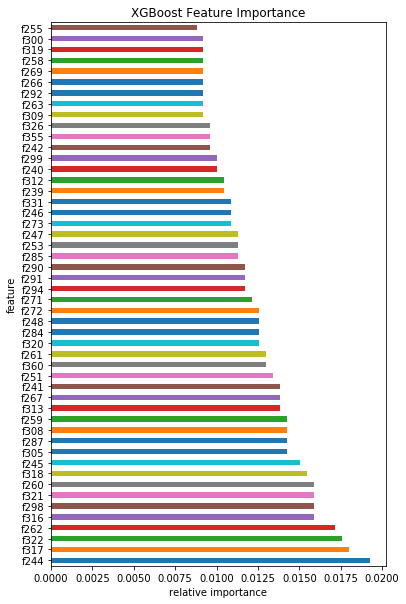

In [241]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance[:50].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

In [242]:
feat_loc = [int(x[1:4]) for x in df_importance.feature ]
orgfeat = [x for x in df.columns.values if x not in ['ID', 'SPENDINGRESPONSE']]
importance_orgfeat = [orgfeat[i-1] for i in feat_loc]

In [243]:
print(importance_orgfeat[0:50])

['f9', 'f84', 'f89', 'f29', 'f83', 'f65', 'f88', 'f27', 'f85', 'f10', 'f72', 'f54', 'f75', 'f26', 'f80', 'f34', 'f6', 'f18', 'State_freq', 'f28', 'f87', 'f51', 'f15', 'f39', 'f38', 'f61', 'f58', 'f57', 'f52', 'f20', 'f14', 'f40', 'f11', 'f111', 'f4', 'f79', 'f5', 'f66', 'f7', 'f143', 'f104', 'f76', 'f30', 'f59', 'f33', 'f36', 'f25', 'f86', 'f67', 'f22']
